## Peptides encoding

In [1]:
import peptides
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# libs for ml
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Fetch all cdr3 sequences from VDJdb ver(vdjdb-2024-11-27-fixed) with `cut -f 2 vdjdb-2024-11-27-fixed/vdjdb.slim.txt | grep -v "cdr3" >cdr3_from_VDJdb.txt`

Set length of sequence: 

In [2]:
len_seq = 15

In [3]:
with open("cdr3_from_VDJdb.txt") as file:
    count = 0
    pep_dir = []
    count_dir = 0
    for pep in file:
        pep = pep[:-1]
        count += 1
        if len(pep) == len_seq:
            count_dir +=1
            pep_dir.append(pep)
    print(f'From {count} only {count_dir} with the lengh of {len_seq}')

From 87032 only 18408 with the lengh of 15


In [4]:
 AA_LIST = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [6]:
pep_oh_encoded = np.zeros((count_dir, len(AA_LIST), len(pep)), dtype = np.float32)
pep_af_encoded = np.zeros((count_dir, 5, len(pep)), dtype = np.float32)
for k, pep in enumerate(pep_dir):
    for i in range(len(pep)):
        for j in range(len(AA_LIST)):
            if AA_LIST[j] == pep[i]:
                pep_oh_encoded[k][j][i] = 1
    for i in range(len(pep)):
        pep1 = peptides.Peptide(pep[i])
        for j, kf in enumerate(pep1.atchley_factors()):
            pep_af_encoded[k][j][i] = kf

In [7]:
print("First peptide (one-hot encoded):\n", pep_oh_encoded[0])
print("First peptide (atchley_factors encoded):\n", np.round(pep_af_encoded[0], 2))
#print(pep_oh_encoded[0].reshape(-1, pep_oh_encoded[0].size))
oh_matr_size = pep_oh_encoded[0].size
af_matr_size = pep_af_encoded[0].size

First peptide (one-hot encoded):
 [[0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
First

### Set Variables

In [8]:
latent_dims = 10
num_epochs = 50 
batch_size = int(count_dir/8) # Тут надо быть аккуратней, чтобы делилось на цело
capacity = 64
learning_rate = 1e-3 
use_gpu = True

### Split datasets

In [9]:
pep_oh_encoded_train = pep_oh_encoded[:int(round(count_dir*0.8, 0))]
print(pep_oh_encoded_train.shape)
pep_oh_encoded_test = pep_oh_encoded[int(round(count_dir*0.8, 0)):]

(14726, 20, 15)


### Loading datasets

In [10]:
oh_dataset = torch.utils.data.TensorDataset(torch.tensor(pep_oh_encoded), torch.tensor(np.ones(count_dir)))
oh_encoded_dl = torch.utils.data.DataLoader(oh_dataset, batch_size=batch_size, shuffle=True)
oh_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_oh_encoded_train), torch.tensor(np.ones(int(round(count_dir*0.8, 0)))))
oh_encoded_dl_train = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=True)

oh_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_oh_encoded_test), torch.tensor(np.ones(count_dir - int(round(count_dir*0.8, 0)))))
oh_encoded_dl_test = torch.utils.data.DataLoader(oh_dataset_test, batch_size=batch_size, shuffle=True)

af_dataset = torch.utils.data.TensorDataset(torch.tensor(pep_af_encoded), torch.tensor(np.ones(count_dir)))
af_encoded_dl = torch.utils.data.DataLoader(oh_dataset, batch_size=batch_size, shuffle=True)

### Autoencoders definition

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(in_features=20*len_seq, out_features=latent_dims)
            
    def forward(self, x):
        x = self.fc(x)
        #x = nn.ReLU(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dims, out_features=20*len_seq)
            
    def forward(self, x):
        x = self.fc(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder = Autoencoder()

if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters: 6310


### Train autoencoder

In [12]:
# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_encoded_dl:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 0.248414
Epoch [2 / 50] average reconstruction error: 0.240150
Epoch [3 / 50] average reconstruction error: 0.227625
Epoch [4 / 50] average reconstruction error: 0.210657
Epoch [5 / 50] average reconstruction error: 0.189878
Epoch [6 / 50] average reconstruction error: 0.166667
Epoch [7 / 50] average reconstruction error: 0.142852
Epoch [8 / 50] average reconstruction error: 0.120245
Epoch [9 / 50] average reconstruction error: 0.100219
Epoch [10 / 50] average reconstruction error: 0.083544
Epoch [11 / 50] average reconstruction error: 0.070377
Epoch [12 / 50] average reconstruction error: 0.060415
Epoch [13 / 50] average reconstruction error: 0.053119
Epoch [14 / 50] average reconstruction error: 0.047877
Epoch [15 / 50] average reconstruction error: 0.044138
Epoch [16 / 50] average reconstruction error: 0.041466
Epoch [17 / 50] average reconstruction error: 0.039541
Epoch [18 / 50] average reconstruction error: 0.038134
Epoch 

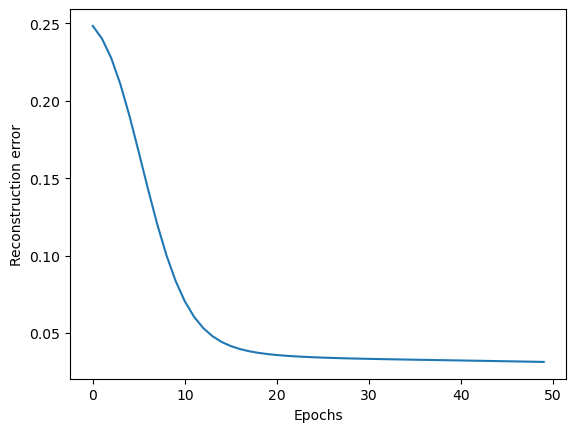

In [13]:
fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [14]:
# set to evaluation mode
autoencoder.eval()

test_loss_avg, num_batches = 0, 0
for pep_batch, _ in oh_encoded_dl_test:
    
    with torch.no_grad():

        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)

        # autoencoder reconstruction
        pep_batch_recon = autoencoder(pep_batch)

        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.032006
